In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine,reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [10]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
import datetime as dt

period_start = dt.date(2016,7,1)
period_end =dt.date(2016,7,8)

TMIN, TAVG,TMAX = calc_temps(period_start.strftime("%Y-%m-%d"),period_end.strftime("%Y-%m-%d"))[0]

print(TMIN,TAVG,TMAX)



71.0 76.95833333333333 82.0


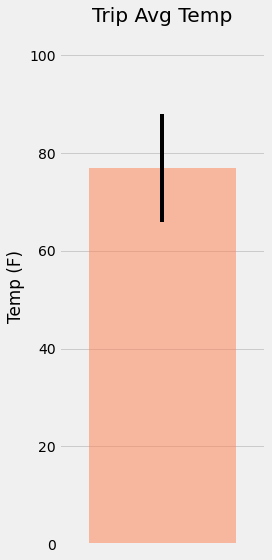

In [11]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

fig, frame = plt.subplots(figsize=plt.figaspect(2.))
x=1
yerr=TMAX-TMIN

bar = frame.bar(x, TAVG, yerr=yerr, alpha=0.5, color='coral', align="center")
frame.set(xticks=range(x), xticklabels="x", title="Trip Avg Temp", ylabel="Temp (F)")
frame.margins(.2,.2)
fig.tight_layout()

### Daily Rainfall Average

In [12]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

start = '2016-07-01'
end = '2016-07-8'

s_list = [Station.station, Station.name, Station.latitude, 
       Station.longitude, Station.elevation, func.sum(Measurement.prcp)]

results = session.query(*s_list).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= start).\
    filter(Measurement.date <= end).\
    group_by(Station.name).order_by(func.sum(Measurement.prcp).desc()).all()

print(results)

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 22.41), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 16.740000000000002), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 10.75), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 6.33), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 6.14), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 2.59), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.51)]


### Daily Temperature Normals

In [13]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [14]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2016-07-01'
end_date = '2016-07-8'

# Use the start and end date to create a range of dates

trip=pd.date_range(start_date,end_date,freq='D')

# Strip off the year and save a list of strings in the format %m-%d

trip_excl_Y = trip.strftime('%m-%d')


# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.

normals=[]

for date in trip_excl_Y:
    normals.append(*daily_normals(date))
normals    

[(67.0, 74.77777777777777, 81.0),
 (68.0, 75.40384615384616, 82.0),
 (68.0, 75.32075471698113, 87.0),
 (70.0, 76.57142857142857, 81.0),
 (66.0, 75.0, 81.0),
 (69.0, 75.0, 81.0),
 (69.0, 74.91071428571429, 82.0),
 (69.0, 76.08333333333333, 83.0)]

In [15]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'])
df['date'] = trip
df.set_index(['date'],inplace=True)
df.head()

,tmin,tavg,tmax
date,,,
2016-07-01,67.0,74.777778,81.0
2016-07-02,68.0,75.403846,82.0
2016-07-03,68.0,75.320755,87.0
2016-07-04,70.0,76.571429,81.0
2016-07-05,66.0,75.000000,81.0


Text(9.310000000000002, 0.5, 'Temperature')

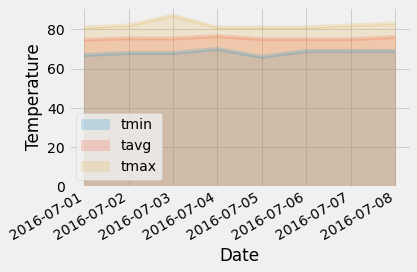

In [16]:
# Plot the daily normals as an area plot with `stacked=False`
df.plot(kind='area', stacked=False, x_compat=True, alpha=.2)
plt.tight_layout()
plt.xlabel("Date")
plt.ylabel("Temperature")


## Close Session

In [17]:
session.close()